In [32]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from difflib import SequenceMatcher

from scipy import signal, fftpack
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Activation, Dropout
from keras import utils
from keras.callbacks import ModelCheckpoint
utils.to_categorical

from tensorflow.keras.utils import to_categorical

In [33]:
# Fungsi untuk ekstraksi fitur highest peak dari PSD
def extract_highest_peak_psd(data, fs, lowcut, highcut, order):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    
    #Filter bandpass
    filtered_signal = signal.filtfilt(b, a, data)
    
    # Rectify signal
    rectified_signal = np.abs(filtered_signal)
    
    # One-sided FFT
    signal_fft = np.fft.fft(filtered_signal)
    signal_freq = np.fft.fftfreq(len(filtered_signal), 1/fs)
    n = len(filtered_signal)
    freq = signal_freq[0:int(n/2)]
    fft_amp = np.abs(signal_fft)[0:int(n/2)]/n*2
    
    # One-sided PSD
    psd = (1/(fs*n)) * np.square(np.abs(signal_fft[:n//2]))
    freq_psd = signal_freq[0:int(n/2)]
    psd_one_side = psd[0:int(n/2)]
    
    # Ekstraksi fitur highest peak dari PSD
    highest_peak_idx = np.argmax(psd_one_side)
    highest_peak_value = psd_one_side[highest_peak_idx]
    return highest_peak_value


In [34]:
# Fungsi untuk membaca dataset dari folder kelas
def read_data_from_folder(folder_path, class_label, fs, lowcut, highcut, order):
    dataframes = []
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        # start_index = 1
        # end_index = 1551
        # df = df[start_index:end_index]
        data = df['Y'].values
        highest_peak_psd = extract_highest_peak_psd(data, fs, lowcut, highcut, order)
        df_highest_peak_psd = pd.DataFrame({'Highest Peak PSD': [highest_peak_psd], 'Class': [class_label]})
        dataframes.append(df_highest_peak_psd)
    return pd.concat(dataframes, ignore_index=True)

# Path ke folder yang berisi dataset untuk masing-masing kelas
class1_folder = 'E:/Pengolahan Data CD Bone-USG/csv-400-400/csv 30%/'
class2_folder = 'E:/Pengolahan Data CD Bone-USG/csv-400-400/csv 50%/'
class3_folder = 'E:/Pengolahan Data CD Bone-USG/csv-400-400/csv 70%/'
class4_folder = 'E:/Pengolahan Data CD Bone-USG/csv-400-400/csv 90%/'

# Parameter filter
fs = 100  # Frekuensi sampling
lowcut = 2.0  # Frekuensi cutoff rendah untuk filter bandpass
highcut = 10  # Frekuensi cutoff tinggi untuk filter bandpass
order = 5  # Order filter

# Membaca data untuk masing-masing kelas
class1_data = read_data_from_folder(class1_folder, class_label=0, fs=fs, lowcut=lowcut, highcut=highcut, order=order)
class2_data = read_data_from_folder(class2_folder, class_label=1, fs=fs, lowcut=lowcut, highcut=highcut, order=order)
class3_data = read_data_from_folder(class3_folder, class_label=2, fs=fs, lowcut=lowcut, highcut=highcut, order=order)
class4_data = read_data_from_folder(class4_folder, class_label=3, fs=fs, lowcut=lowcut, highcut=highcut, order=order)

In [37]:
# Menggabungkan data dari masing-masing kelas menjadi satu DataFrame utama
combined_data = pd.concat([class1_data, class2_data, class3_data, class4_data])

# Memisahkan fitur highest peak PSD dan label kelas
X = np.array(combined_data['Highest Peak PSD'].values.tolist())
y = np.array(combined_data['Class'].values)

# One-hot encode label kelas
y_encoded = to_categorical(y, num_classes=4)

# Memisahkan data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Mengubah bentuk data untuk LSTM (tambahkan dimensi waktu)
X_train_lstm = np.expand_dims(X_train, axis=1)
X_test_lstm = np.expand_dims(X_test, axis=1)

In [39]:
# Membuat model LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], 1)))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Menyimpan model terbaik selama pelatihan
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Melatih model
history = model.fit(X_train_lstm, y_train, validation_data=(X_test_lstm, y_test), epochs=50, batch_size=16, callbacks=[checkpoint])

Epoch 1/50
1/5 [=====>........................] - ETA: 18s - loss: 1.3862 - accuracy: 0.1875
Epoch 1: val_accuracy improved from -inf to 0.15000, saving model to best_model.h5
5/5 [==============================] - 7s 504ms/step - loss: 1.3863 - accuracy: 0.2500 - val_loss: 1.3874 - val_accuracy: 0.1500
Epoch 2/50
1/5 [=====>........................] - ETA: 0s - loss: 1.3853 - accuracy: 0.2500
Epoch 2: val_accuracy did not improve from 0.15000
5/5 [==============================] - 0s 29ms/step - loss: 1.3861 - accuracy: 0.2750 - val_loss: 1.3879 - val_accuracy: 0.1500
Epoch 3/50
1/5 [=====>........................] - ETA: 0s - loss: 1.3868 - accuracy: 0.3125
Epoch 3: val_accuracy did not improve from 0.15000
5/5 [==============================] - 0s 25ms/step - loss: 1.3861 - accuracy: 0.2750 - val_loss: 1.3887 - val_accuracy: 0.1500
Epoch 4/50
1/5 [=====>........................] - ETA: 0s - loss: 1.3872 - accuracy: 0.1875
Epoch 4: val_accuracy did not improve from 0.15000
5/5 [=====

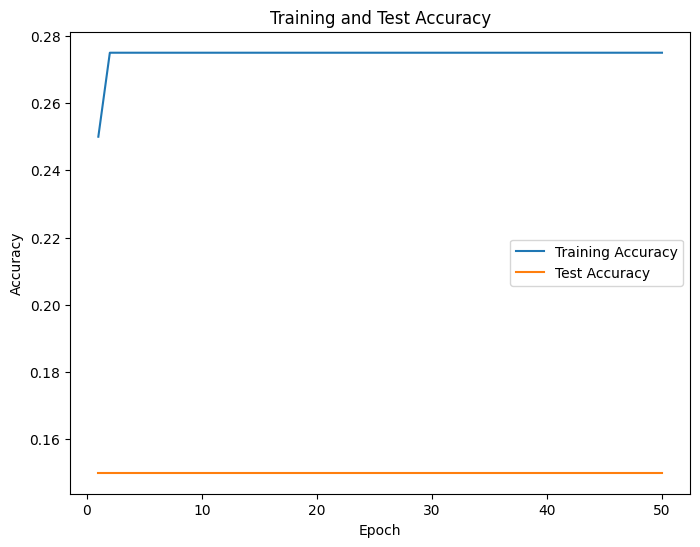

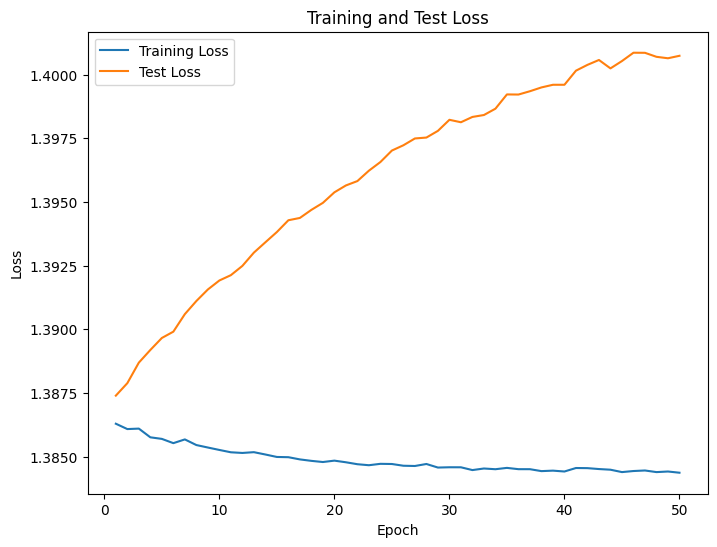

In [41]:
# Ambil histori akurasi dan loss dari proses pelatihan
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Buat plot untuk akurasi
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(test_accuracy) + 1), test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()

# Buat plot untuk loss 
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(test_loss) + 1), test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluasi performa model
accuracy = model.evaluate(X_test_lstm, y_test)[1]
print("Akurasi pada data uji:", accuracy)

# Simpan model terbaik untuk digunakan pada data baru
best_model = load_model('best_model.h5')

1/1 [==============================] - 0s 44ms/step - loss: 1.3978 - accuracy: 0.1500
Akurasi pada data uji: 0.15000000596046448
